Teach a Seq2Seq Model to learn how to talk with General Adversarial Imitation Learning. Using a model + discriminator, teach the discriminator how to tell the difference between fake and real responses, and train the model using the policy gradient to fool the discriminator. Through this game, we can replicate conversations and see how the reward function produced by the discriminator evolves!

In [1]:
import gensim
import torch
import sys
sys.path.append('../src')
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
from models.utils import get_model
from models.config import TOKENS_RAW_CUTOFF
from models.seq2seqattn import init_weights, EncRnn, DecRnn, Seq2SeqAttn
from collections import deque
torch.autograd.set_detect_anomaly(True)

#Load in models and helper functions

w2v_model = gensim.models.Word2Vec.load('../models/custom_w2v_intersect_GoogleNews_seq2seqattn') #get_model()
# w2ind from w2v
w2ind = {token: token_index for token_index, token in enumerate(w2v_model.wv.index2word)} 
# sorted vocab words
assert w2v_model.vocabulary.sorted_vocab == True
word_counts = {word: vocab_obj.count for word, vocab_obj in w2v_model.wv.vocab.items()}
word_counts = sorted(word_counts.items(), key=lambda x:-x[1])
words = [t[0] for t in word_counts]
# sentence marker token inds
sos_ind = w2ind['<sos>']
eos_ind = w2ind['<eos>']
# adjusted sequence length
SEQ_LEN = 5 + 2 # sos, eos tokens
# padding token for now
TRG_PAD_IDX = w2ind["."] # this is 0
# vocab, embed dims
VOCAB_SIZE, EMBED_DIM = w2v_model.wv.vectors.shape
VOCAB_SIZE, EMBED_DIM


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [2]:
class Discriminator(nn.Module):
    def __init__(self,model,SEQ_LEN):
        super(Discriminator, self).__init__()

        self.state_encoder = model.encoder
        self.action_encoder = model.encoder
        
        self.fc1 = nn.Linear(2560,512)
        self.fc2 = nn.Linear(512,64)
        self.fc3 = nn.Linear(64,1)
        self.src_len = torch.Tensor([int(SEQ_LEN)])
    def forward(self,x1,x2):
        state_z, _ = self.state_encoder(x1, self.src_len)
        action_z, _ = self.action_encoder(x2, self.src_len)

        state_action = torch.cat([state_z.flatten().unsqueeze(0), action_z.flatten().unsqueeze(0)],dim=1)
        
        state_action = torch.relu(self.fc1(state_action))
        state_action = torch.relu(self.fc2(state_action))
        state_action = torch.sigmoid(self.fc3(state_action))

        return state_action

In [3]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
enc = EncRnn(hidden_size=128, num_layers=2, embed_size=EMBED_DIM)
dec = DecRnn(hidden_size=128, num_layers=2, embed_size=EMBED_DIM, output_size=VOCAB_SIZE)
enc_ = EncRnn(hidden_size=128, num_layers=2, embed_size=EMBED_DIM)
dec_ = DecRnn(hidden_size=128, num_layers=2, embed_size=EMBED_DIM, output_size=VOCAB_SIZE)
agent = Seq2SeqAttn(enc, dec, TRG_PAD_IDX, VOCAB_SIZE, device).to(device)
# load in pre-trained model 
agent_ = Seq2SeqAttn(enc_, dec_, TRG_PAD_IDX, VOCAB_SIZE, device).to(device)
agent.load_state_dict(torch.load(
    '/scratch/nsk367/deepRL/limitation-learning/src/pretrained_generators/model-epoch20.pt'))
agent_.load_state_dict(torch.load(
    '/scratch/nsk367/deepRL/limitation-learning/src/pretrained_generators/model-epoch20.pt'))


discrim = Discriminator(model=agent_,SEQ_LEN=5).to(device)

In [4]:
# load in conversations (as a dictionary)
d = torch.load('../dat/processed/padded_vectorized_states_v3.pt')


In [5]:
import random
import math

In [6]:
def get_action_probs(model, input_state, sos_ind, eos_ind, SEQ_LEN, device):
    """
    Given an input sequence and policy, produce a distribution over tokens the predicted token for each step in the sequence. 
    """
    src_tensor = input_state.reshape(1,7).to(device)
    src_len = torch.Tensor([int(SEQ_LEN)])
    encoder_outputs, hidden = model.encoder(src_tensor, src_len)
    #print('encoutshape',encoder_outputs.shape)
    mask = model.create_mask(src_tensor.transpose(1,0)).to(device)
    trg_indexes = [sos_ind]
    attentions = torch.zeros(SEQ_LEN, 1, len(input_state))
    outputs = []
    for i in range(SEQ_LEN):
        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
        output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs, mask)
        attentions[i] = attention
        pred_token = output.argmax(1).item()
        trg_indexes.append(pred_token)
       # print(pred_token)
        if pred_token == eos_ind: # end of sentence.
        
            break
        outputs.append(output)
        
  #  trg_tokens = [words[int(ind)] for ind in trg_indexes]
    #  remove <sos>
    return F.softmax(torch.stack(outputs),dim=2).to(device)



    

In [7]:
def pad_action(action):
    num_pads = 7 - action.shape[0] - 2
    if num_pads == 0:
        action = torch.cat((torch.LongTensor([sos_ind]), 
                        action.cpu()[1:-1],
                        torch.LongTensor([eos_ind])), 
                       dim=0).to(device)
    if num_pads == 0:
        action =torch.cat((torch.LongTensor([sos_ind]), 
                        action.cpu()[1:-1],torch.LongTensor([0]),
                        torch.LongTensor([eos_ind])), 
                       dim=0).to(device)
        
    if num_pads == 1:
        action = torch.cat((torch.LongTensor([sos_ind]), 
                        action.cpu()[1:-1],torch.LongTensor([0]),
                            torch.LongTensor([0]),
                        torch.LongTensor([eos_ind])), 
                       dim=0).to(device)
    if num_pads == 2:
        action = torch.cat((torch.LongTensor([sos_ind]), 
                        action.cpu()[1:-1],torch.LongTensor([0]),
                            torch.LongTensor([0]),
                            torch.LongTensor([0]),

                        torch.LongTensor([eos_ind])), 
                       dim=0).to(device)
    if num_pads == 3:
        action = torch.cat((torch.LongTensor([sos_ind]), 
                        action.cpu()[1:-1],torch.LongTensor([0]),
                            torch.LongTensor([0]),
                            torch.LongTensor([0]),
                            torch.LongTensor([0]),


                        torch.LongTensor([eos_ind])), 
                       dim=0).to(device)
    if num_pads == 4:
        action = torch.cat((torch.LongTensor([sos_ind]), 
                        action.cpu()[1:-1],torch.LongTensor([0]),
                            torch.LongTensor([0]),
                            torch.LongTensor([0]),
                            torch.LongTensor([0]),
                            torch.LongTensor([0]),


                        torch.LongTensor([eos_ind])), 
                       dim=0).to(device)
    if num_pads == 5:
        action = torch.cat((torch.LongTensor([sos_ind]), 
                        action.cpu()[1:-1],torch.LongTensor([0]),
                            torch.LongTensor([0]),
                            torch.LongTensor([0]),
                            torch.LongTensor([0]),
                            torch.LongTensor([0]),
                            torch.LongTensor([0]),

                        torch.LongTensor([eos_ind])), 
                       dim=0).to(device)
    return action

In [8]:
def get_action(action_probs):
    action = []
    action_log_probs = []
    for i in action_probs:
        m = Categorical(i)
        action_ = m.sample()
        action_log_prob = m.log_prob(action_)# * reward
        action.append(action_.item())
        action_log_probs.append(action_log_prob)
    action = torch.Tensor(action).to(device).long()
    return action, torch.stack(action_log_probs)#.squeeze()

def get_reward(discrim, state, action):
    """
    The reward function according to irl. It's log D(s,a). 
    
    Reward is higher the closer this is to 0, because the more similar it is to an expert action. :
    Is quite close to imitation learning, but hope here is that with such a large number of expert demonstrations and entropy bonuses etc. it learns more than direct imitation. 
    """
    state = state.unsqueeze(0)
    action = action.unsqueeze(0)
    
    with torch.no_grad():
        #TODO: better resize
        return -math.log(discrim(state,action))
    
def train_discrim(memory, discrim_optim, args):
    """
    Training the discriminator. 

    Use binary cross entropy to classify whether 
    or not a sequence was predicted by the expert (real data) or actor. 
    """
    
    criterion = torch.nn.BCELoss() # classify
    learner = torch.stack([memory[i][0] for i in range(len(memory))])
    expert = torch.stack([memory[i][1] for i in range(len(memory))])
    policy_optim.zero_grad()
    discrim_optim.zero_grad()
    # actions came from expert or learner
    discrim_loss = criterion(learner.squeeze(1), torch.ones((args.batch_size, 1)).to(device)) + \
                    criterion(expert.squeeze(1), torch.zeros((args.batch_size, 1)).to(device))
            # discrim loss: predict agent is all wrong, get as close to 0, and predict expert is 1, getting as close to 1 as possible. 
    discrim_loss.backward()

    for _ in range(args.discrim_update_num):
        discrim_optim.step()
            # take these steps, do it however many times specified. 
        #return discrim(states,expert_actions) , discrim(states,actions)
    expert_acc = ((expert < 0.5).float()).mean().item()
    learner_acc = ((learner > 0.5).float()).mean().item()


    return discrim_loss.item(), expert_acc, learner_acc # accuracy, it's the same kind, but because imbalanced better to look at separately. 

def train_policy(memory, policy_optim, args):
    """
    Take several Policy Gradient steps to imporve the policy
    
    using the single step returns to optimize objective. 
    
    
    
    """
    
    rlog_probs = torch.stack([memory[i][0] for i in range(len(memory))])
    policy_optim.zero_grad()
    discrim_optim.zero_grad()

    policy_loss = rlog_probs.mean()
    policy_loss.backward()
    
    for _ in range(args.actor_critic_update_num):

        policy_optim.step()
    return policy_loss.item()

In [9]:
import torch.optim as optim


In [11]:
from argparse import Namespace
args = Namespace(load_model=None,
                agent_learning_rate=1e-5,
                discrim_learning_rate=1e-4,
                l2_rate = 1e-5, # because the policy is so sensitve we only make the tiniest of updates
                discrim_update_num=5,
                actor_critic_update_num=1,
                batch_size=256,
                suspend_accu_exp=None,# won't stop
                suspend_accu_gen=None,
                max_iter_num=50,
                logdir='logs/GAIL',
                )

In [12]:

policy_optim = optim.Adam(agent.parameters(), lr=args.agent_learning_rate,weight_decay=args.l2_rate)

discrim_optim = optim.Adam(discrim.parameters(), lr=args.discrim_learning_rate)


In [13]:
train_discrim_flag = True
train_policy_flag = True
policy_losses = []
discrim_losses = []
expert_accs = []
learner_accs = []
scores = []
for step in range(args.max_iter_num):
    score = 0
    discrim_memory = deque()
    learner_memory = deque()
    trajectories = random.sample(d.items(),k=args.batch_size)
    for (index, vects) in trajectories:
        input_state, expert_action = vects
        input_state = torch.cat((torch.LongTensor([sos_ind]), 
                                 input_state,
                                 torch.LongTensor([eos_ind])), 
                                 dim=0).to(device)
        expert_action = torch.cat((torch.LongTensor([sos_ind]), 
                                expert_action, 
                                torch.LongTensor([eos_ind])), 
                               dim=0).to(device)
        action_probs =  get_action_probs(agent, input_state, sos_ind, eos_ind, SEQ_LEN, device)
        action, action_log_probs = get_action(action_probs)
       # print(action)]
        action = action.detach()
        action = pad_action(action)
        #print(action)
    
        #obtain what the estimated reward is for this 
        irl_reward = get_reward(discrim,input_state,action)
        score += irl_reward
        learner = discrim(input_state.unsqueeze(0).detach(), action.unsqueeze(0).detach()) #pass (s,a) through discriminator
        expert = discrim(input_state.unsqueeze(0), expert_action.unsqueeze(0)) #pass (s,a) through discriminator

        discrim_memory.append([learner,expert])
        learner_memory.append([(-irl_reward  * action_log_probs).sum()])
    if train_policy_flag:
        policy_loss = train_policy(learner_memory, policy_optim, args)   
        policy_losses.append(policy_loss)
    scores.append(score)
    if train_discrim_flag:
        discrim_loss, expert_acc, learner_acc = train_discrim(discrim_memory, discrim_optim, args) 
        print("Expert: %.2f%% | Learner: %.2f%%" % (expert_acc * 100, learner_acc * 100))
        discrim_losses.append(discrim_loss)
        expert_accs.append(100*expert_acc)
        learner_accs.append(100*learner_acc)


      #  writer.add_scalar('log/expert_acc', float(expert_acc), iter) #logg
      #  writer.add_scalar('log/learner_acc', float(learner_acc), iter) #logg
      #  writer.add_scalar('log/avg_acc', float(learner_acc + expert_acc)/2, iter) #logg
        if args.suspend_accu_exp is not None: #only if not None do we check.
            if expert_acc > args.suspend_accu_exp and learner_acc > args.suspend_accu_gen:
                train_discrim_flag = False
  
    expert_tokens = " ".join([words[int(ind)] for ind in expert_action])
    action_tokens = " ".join([words[int(ind)] for ind in action])
    state_tokens = " ".join([words[int(ind)] for ind in input_state])
    print(state_tokens,'|',action_tokens,'|',expert_tokens)



Expert: 1.95% | Learner: 99.22%
<sos> here 's the card ? <eos> | <sos> was the was . <eos> | <sos> when was they here ? <eos>
Expert: 28.12% | Learner: 93.75%
<sos> here you go ... . <eos> | <sos> ... ... rub . <eos> | <sos> you're kidding me ... . <eos>
Expert: 48.83% | Learner: 82.81%
<sos> ya catch any fish ? <eos> | <sos> , <person> ... . <eos> | <sos> ... what ? . . <eos>
Expert: 57.42% | Learner: 74.22%
<sos> that was for <date> . <eos> | <sos> got any ? . <eos> | <sos> i was missing you . <eos>
Expert: 58.20% | Learner: 78.52%
<sos> got it ! . . <eos> | <sos> ? he ? . <eos> | <sos> got what ? . . <eos>
Expert: 70.70% | Learner: 72.66%
<sos> no , this hurts . <eos> | <sos> ! ! ! . <eos> | <sos> <org> ! . . . <eos>
Expert: 71.09% | Learner: 74.61%
<sos> everything about sex . . <eos> | <sos> what ? . . <eos> | <sos> like what ? . . <eos>
Expert: 69.92% | Learner: 76.56%
<sos> what do you say ? <eos> | <sos> 'd she say . <eos> | <sos> not interested . . . <eos>
Expert: 66.41% | Lea

Now examine the results as plots

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline



Text(0, 0.5, 'Accuracy')

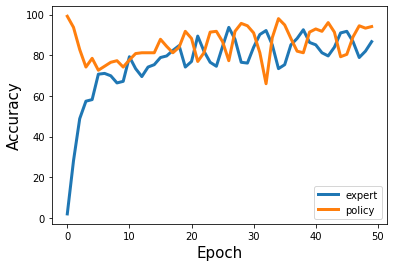

In [15]:
plt.plot(expert_accs,linewidth=3,label='expert')
plt.plot(learner_accs,linewidth=3,label='policy')
plt.legend()
plt.xlabel("Epoch",fontsize=15)
plt.ylabel("Accuracy",fontsize=15)

Text(0, 0.5, 'Discriminator Loss')

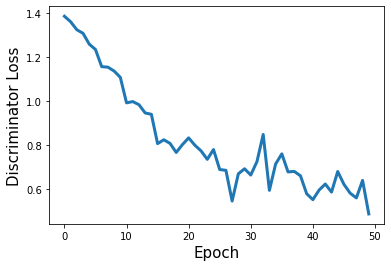

In [16]:
plt.plot(discrim_losses,linewidth=3)
plt.xlabel("Epoch",fontsize=15)
plt.ylabel("Discriminator Loss",fontsize=15)

Text(0, 0.5, 'Policy Loss')

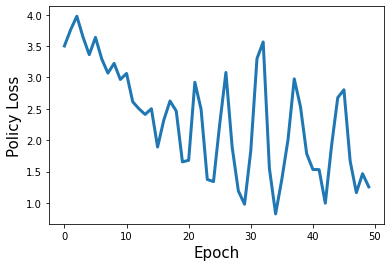

In [17]:
plt.plot(policy_losses,linewidth=3)
plt.xlabel("Epoch",fontsize=15)
plt.ylabel("Policy Loss",fontsize=15)

# Policy Analysis


Using our best policy model, print states with the highest rewards. 


In [57]:
best_reward = 0
i = 0
j = 0
for step in range(1):
    while j < 10:
        trajectories = d.items() #random.sample(d.items(),k=6000)
        for (index, vects) in trajectories:
            i = 0

            while i < 3:
                input_state, expert_action = vects
                input_state = torch.cat((torch.LongTensor([sos_ind]), 
                                         input_state,
                                         torch.LongTensor([eos_ind])), 
                                         dim=0).to(device)
                expert_action = torch.cat((torch.LongTensor([sos_ind]), 
                                        expert_action, 
                                        torch.LongTensor([eos_ind])), 
                                       dim=0).to(device)
                action_probs =  get_action_probs(agent, input_state, sos_ind, eos_ind, SEQ_LEN, device)
                action, action_log_probs = get_action(action_probs)
                action = action.detach()
                action = pad_action(action)
                reward =  get_reward(discrim,input_state,action)

                if reward > 0:
                    #print("New best!")
                    print(reward)
                    action_tokens = [words[int(ind)] for ind in action]
                  #  best_reward = reward

                    expert_tokens = " ".join([words[int(ind)] for ind in expert_action])
                    action_tokens = " ".join([words[int(ind)] for ind in action])
                    state_tokens = " ".join([words[int(ind)] for ind in input_state])
                    print(state_tokens,'|',action_tokens,'|',expert_tokens)
                i += 1
                

        j += 1

0.3916560243457595
<sos> <time> <time> to go ! <eos> | <sos> you yes here . <eos> | <sos> yes . . . . <eos>
0.3393934312647262
<sos> <time> <time> to go ! <eos> | <sos> you yes ? . <eos> | <sos> yes . . . . <eos>
0.024376290111831275
<sos> <time> <time> to go ! <eos> | <sos> you after ? . <eos> | <sos> yes . . . . <eos>
0.003063419036240702
<sos> <org> . . . . <eos> | <sos> ? ? ? . <eos> | <sos> i hate him . . <eos>
0.003063419036240702
<sos> <org> . . . . <eos> | <sos> ? ? ? . <eos> | <sos> i hate him . . <eos>
0.003063419036240702
<sos> <org> . . . . <eos> | <sos> ? ? ? . <eos> | <sos> i hate him . . <eos>
0.21525262398935044
<sos> good <time> , doctor . <eos> | <sos> <time> you captain . <eos> | <sos> good <time> ! . . <eos>
0.06961117979636251
<sos> good <time> , doctor . <eos> | <sos> <time> ! ! . <eos> | <sos> good <time> ! . . <eos>
0.09115971795700656
<sos> good <time> , doctor . <eos> | <sos> day , ! . <eos> | <sos> good <time> ! . . <eos>
0.14271817710285953
<sos> i think so 

1.39480650575352
<sos> surprised ! . . . <eos> | <sos> me ? . . <eos> | <sos> love me ? . . <eos>
1.39480650575352
<sos> surprised ! . . . <eos> | <sos> me ? . . <eos> | <sos> love me ? . . <eos>
0.00472881125407285
<sos> darling ! . . . <eos> | <sos> ? ? ! . <eos> | <sos> any luck ? . . <eos>
0.003498527668667306
<sos> darling ! . . . <eos> | <sos> ! ? ! . <eos> | <sos> any luck ? . . <eos>
0.00472881125407285
<sos> darling ! . . . <eos> | <sos> ? ? ! . <eos> | <sos> any luck ? . . <eos>
0.10480140822832965
<sos> goodbye , darling ! . <eos> | <sos> ! darling ! . <eos> | <sos> darling ! . . . <eos>
0.10480140822832965
<sos> goodbye , darling ! . <eos> | <sos> ! darling ! . <eos> | <sos> darling ! . . . <eos>
0.06597273088756143
<sos> goodbye , darling ! . <eos> | <sos> ! hurry ! . <eos> | <sos> darling ! . . . <eos>
0.12277141662469072
<sos> will you miss me ? <eos> | <sos> , sir ? . <eos> | <sos> very .... very ! . <eos>
0.01101494158726175
<sos> will you miss me ? <eos> | <sos> , ver

0.8372071238314767
<sos> what are you ? . <eos> | <sos> me ! . . <eos> | <sos> you know . . . <eos>
0.8372071238314767
<sos> what are you ? . <eos> | <sos> me ! . . <eos> | <sos> you know . . . <eos>
0.15318100504726467
<sos> yes it does . . <eos> | <sos> things you it . <eos> | <sos> oh , come on ! <eos>
0.25465965705655563
<sos> yes it does . . <eos> | <sos> anyone ? ? . <eos> | <sos> oh , come on ! <eos>
0.030027168381384143
<sos> yes it does . . <eos> | <sos> 've this ? . <eos> | <sos> oh , come on ! <eos>
0.24693645108713883
<sos> up yours . . . <eos> | <sos> in back ? . <eos> | <sos> i heard that . . <eos>
0.24693645108713883
<sos> up yours . . . <eos> | <sos> in back ? . <eos> | <sos> i heard that . . <eos>
0.24693645108713883
<sos> up yours . . . <eos> | <sos> in back ? . <eos> | <sos> i heard that . . <eos>
0.2676057874242337
<sos> i 'm terribly sorry . <eos> | <sos> 's come then . <eos> | <sos> -- never mind . . <eos>
0.0587998486752725
<sos> i 'm terribly sorry . <eos> | <so

0.5506153575632666
<sos> well -- . . . <eos> | <sos> what ? ! . <eos> | <sos> about what ? . . <eos>
0.5506153575632666
<sos> well -- . . . <eos> | <sos> what ? ! . <eos> | <sos> about what ? . . <eos>
0.5506153575632666
<sos> well -- . . . <eos> | <sos> what ? ! . <eos> | <sos> about what ? . . <eos>
0.1898520380477272
<sos> it makes you nervous ? <eos> | <sos> , yes . . <eos> | <sos> yes . . . . <eos>
0.1898520380477272
<sos> it makes you nervous ? <eos> | <sos> , yes . . <eos> | <sos> yes . . . . <eos>
0.1898520380477272
<sos> it makes you nervous ? <eos> | <sos> , yes . . <eos> | <sos> yes . . . . <eos>
0.011247229163458394
<sos> oh , no ! . <eos> | <sos> ? ! ! . <eos> | <sos> the end . . . <eos>
0.011247229163458394
<sos> oh , no ! . <eos> | <sos> ? ! ! . <eos> | <sos> the end . . . <eos>
0.011247229163458394
<sos> oh , no ! . <eos> | <sos> ? ! ! . <eos> | <sos> the end . . . <eos>
0.19522681448453663
<sos> ... to <person> ! . <eos> | <sos> killed go ask . <eos> | <sos> oh -- . . 

0.03228068242471624
<sos> no -- . . . <eos> | <sos> ? it ? . <eos> | <sos> what do you think ? <eos>
0.38652500581718563
<sos> no -- . . . <eos> | <sos> are what ? . <eos> | <sos> what do you think ? <eos>
2.4487154935134794
<sos> <person> , too . . <eos> | <sos> what <person> ? . <eos> | <sos> oh , now ? . <eos>
0.008561078768233798
<sos> <person> , too . . <eos> | <sos> ? , ! . <eos> | <sos> oh , now ? . <eos>
0.0030612666878821627
<sos> <person> , too . . <eos> | <sos> ? ? ? . <eos> | <sos> oh , now ? . <eos>
0.06181922728422011
<sos> ... <person> , too ? <eos> | <sos> ? , ... . <eos> | <sos> <person> , too . . <eos>
0.02598992181128929
<sos> ... <person> , too ? <eos> | <sos> ? ! partner . <eos> | <sos> <person> , too . . <eos>
0.15583415902728576
<sos> ... <person> , too ? <eos> | <sos> for dear ! . <eos> | <sos> <person> , too . . <eos>
2.637387246827925
<sos> oh ! well .... . <eos> | <sos> my god . . <eos> | <sos> <person> 's my dog . <eos>
1.0039317103956522
<sos> oh ! well ...

0.15857769530135216
<sos> shut up . . . <eos> | <sos> great n't ! . <eos> | <sos> does it hurt ? . <eos>
0.33290806304197357
<sos> shut up . . . <eos> | <sos> wo n't place . <eos> | <sos> does it hurt ? . <eos>
0.09259590095295794
<sos> are you sure ? . <eos> | <sos> , sir . . <eos> | <sos> yes , sir . . <eos>
0.09259590095295794
<sos> are you sure ? . <eos> | <sos> , sir . . <eos> | <sos> yes , sir . . <eos>
0.18044251066245842
<sos> are you sure ? . <eos> | <sos> am sir . . <eos> | <sos> yes , sir . . <eos>
0.13280475250352836
<sos> me neither ! . . <eos> | <sos> 're all nervous . <eos> | <sos> are you sure ? . <eos>
0.151005099712883
<sos> me neither ! . . <eos> | <sos> sure ... time . <eos> | <sos> are you sure ? . <eos>
0.16108121957026472
<sos> me neither ! . . <eos> | <sos> it ... time . <eos> | <sos> are you sure ? . <eos>
0.018358530859014018
<sos> <org> is running out . <eos> | <sos> ! ! ! . <eos> | <sos> surrender ! ! . . <eos>
0.018358530859014018
<sos> <org> is running out

0.11912268270690472
<sos> good thinking . . . <eos> | <sos> ? ? when . <eos> | <sos> we set ? . . <eos>
0.025082449299479018
<sos> good thinking . . . <eos> | <sos> ? , ? . <eos> | <sos> we set ? . . <eos>
0.08825953995247712
<sos> nothing . . . . <eos> | <sos> red tape ? . <eos> | <sos> bullshit red tape . . <eos>
0.08825953995247712
<sos> nothing . . . . <eos> | <sos> red tape ? . <eos> | <sos> bullshit red tape . . <eos>
0.08825953995247712
<sos> nothing . . . . <eos> | <sos> red tape ? . <eos> | <sos> bullshit red tape . . <eos>
0.4654862790362701
<sos> you are . . . <eos> | <sos> work came you . <eos> | <sos> <person> . . . . <eos>
0.04459184329690281
<sos> you are . . . <eos> | <sos> funny ! <time> . <eos> | <sos> <person> . . . . <eos>
0.09267011839302455
<sos> you are . . . <eos> | <sos> you came <person> . <eos> | <sos> <person> . . . . <eos>
0.10997796293673649
<sos> you can trust me . <eos> | <sos> anything not drunk . <eos> | <sos> i 'm not drunk ... <eos>
0.109661511290344

0.012159362122984069
<sos> hi <person> , <person> . <eos> | <sos> , he ? . <eos> | <sos> who exactly are you ? <eos>
0.02518409466792235
<sos> hi <person> , <person> . <eos> | <sos> , <person> <cardinal> . <eos> | <sos> who exactly are you ? <eos>
0.09119595653259552
<sos> hi <person> , <person> . <eos> | <sos> , hi ? . <eos> | <sos> who exactly are you ? <eos>
0.02723963221023012
<sos> and i was wondering . <eos> | <sos> ? <person> ? . <eos> | <sos> yes ? . . . <eos>
0.02723963221023012
<sos> and i was wondering . <eos> | <sos> ? <person> ? . <eos> | <sos> yes ? . . . <eos>
0.041209832703401256
<sos> and i was wondering . <eos> | <sos> ? i ? . <eos> | <sos> yes ? . . . <eos>
0.030267539774463552
<sos> hurry . . . . <eos> | <sos> ? , ? . <eos> | <sos> what ... ? . . <eos>
0.0033856658907017697
<sos> hurry . . . . <eos> | <sos> ? ? ? . <eos> | <sos> what ... ? . . <eos>
0.044815856084893364
<sos> hurry . . . . <eos> | <sos> ? up ? . <eos> | <sos> what ... ? . . <eos>
0.20257557894510264

0.051125235960238824
<sos> do you know it ? <eos> | <sos> , too know . <eos> | <sos> every word . . . <eos>
0.03821275364093639
<sos> do you know it ? <eos> | <sos> , i ? . <eos> | <sos> every word . . . <eos>
0.006997273285624
<sos> she 's gone . . <eos> | <sos> ? this ? . <eos> | <sos> what ? . . . <eos>
0.014787091565612429
<sos> she 's gone . . <eos> | <sos> ? you ? . <eos> | <sos> what ? . . . <eos>
0.014787091565612429
<sos> she 's gone . . <eos> | <sos> ? you ? . <eos> | <sos> what ? . . . <eos>
0.22133691345558834
<sos> i was there . . <eos> | <sos> ? asleep ? . <eos> | <sos> see ? . . . <eos>
0.08537761601429315
<sos> i was there . . <eos> | <sos> ? see ... . <eos> | <sos> see ? . . . <eos>
0.051262752179150994
<sos> i was there . . <eos> | <sos> ? died ? . <eos> | <sos> see ? . . . <eos>
0.0026372248612255723
<sos> " you know ... " <eos> | <sos> ? ? ? . <eos> | <sos> what ? . . . <eos>
0.0026372248612255723
<sos> " you know ... " <eos> | <sos> ? ? ? . <eos> | <sos> what ? . .

KeyboardInterrupt: 

In [19]:
best_reward = 0
for step in range(1):
    trajectories = d.item()[:10] #random.sample(d.items(),k=6000)
    for (index, vects) in trajectories:
        input_state, expert_action = vects
        input_state = torch.cat((torch.LongTensor([sos_ind]), 
                                 input_state,
                                 torch.LongTensor([eos_ind])), 
                                 dim=0).to(device)
        expert_action = torch.cat((torch.LongTensor([sos_ind]), 
                                expert_action, 
                                torch.LongTensor([eos_ind])), 
                               dim=0).to(device)
        action_probs =  get_action_probs(agent, input_state, sos_ind, eos_ind, SEQ_LEN, device)
        action, action_log_probs = get_action(action_probs)
        action = action.detach()
        action = pad_action(action)
        reward =  get_reward(discrim,input_state,action)
        
        if reward > 3:
            print("New best!")
            print(reward)
            action_tokens = [words[int(ind)] for ind in action]
            best_reward = reward
        
            expert_tokens = " ".join([words[int(ind)] for ind in expert_action])
            action_tokens = " ".join([words[int(ind)] for ind in action])
            state_tokens = " ".join([words[int(ind)] for ind in input_state])
            print(state_tokens,'|',action_tokens,'|',expert_tokens)



New best!
4.238232139226052
<sos> i was just wondering . <eos> | ok what ? she good ? | <sos> wondering what ? . . <eos>
New best!
3.249298230695215
<sos> ... <person> i do ? <eos> | <sos> believe you funny . <eos> | <sos> so you believe me ? <eos>
New best!
4.449804624727924
<sos> ahh ! ! ! . <eos> | mister <person> ... save ! <eos> | <sos> did i do good ? <eos>
New best!
3.5649727096314145
<sos> alone at last . . <eos> | <sos> what for <gpe> . <eos> | <sos> now where were we ? <eos>
New best!
4.424181532535247
<sos> i said you win . <eos> | win what ? the what ? | <sos> win what ? . . <eos>
New best!
3.547966167314069
<sos> <date> <date> <date> .... . <eos> | <sos> what ? . . <eos> | <sos> what for ? . . <eos>
New best!
3.359014133358539
<sos> speak <language> ! . . <eos> | no said speak <norp> ? ! | <sos> you said speak <norp> ! <eos>
New best!
3.6775716439856305
<sos> i found it ... . <eos> | <sos> what ? . . <eos> | <sos> and ? . . . <eos>
New best!
3.837255883225862
<sos> why so 

In [20]:
worst_reward = 10
for step in range(1):
    trajectories = random.sample(d.items(),k=6000)
    for (index, vects) in trajectories:
        input_state, expert_action = vects
        input_state = torch.cat((torch.LongTensor([sos_ind]), 
                                 input_state,
                                 torch.LongTensor([eos_ind])), 
                                 dim=0).to(device)
        expert_action = torch.cat((torch.LongTensor([sos_ind]), 
                                expert_action, 
                                torch.LongTensor([eos_ind])), 
                               dim=0).to(device)
        action_probs =  get_action_probs(agent, input_state, sos_ind, eos_ind, SEQ_LEN, device)
        action, action_log_probs = get_action(action_probs)
        action = action.detach()
        action = pad_action(action)
        reward =  get_reward(discrim,input_state,action)
        
        if reward < worst_reward:
            print("New worst!")
            print(reward)
            action_tokens = [words[int(ind)] for ind in action]
            worst_reward = reward
        
            expert_tokens = " ".join([words[int(ind)] for ind in expert_action])
            action_tokens = " ".join([words[int(ind)] for ind in action])
            state_tokens = " ".join([words[int(ind)] for ind in input_state])
            print(state_tokens,'|',action_tokens,'|',expert_tokens)



New worst!
1.5181666475984312
<sos> <cardinal> ? . . . <eos> | <sos> change . . . <eos> | <sos> pick me up ? . <eos>
New worst!
0.189886342161046
<sos> <org> probably right . . <eos> | <sos> care , ? . <eos> | <sos> i usually am . . <eos>
New worst!
0.1051442668990763
<sos> can you see anything ? <eos> | <sos> wo , - . <eos> | <sos> what is it ? . <eos>
New worst!
0.10373802988513361
<sos> it 's <person> time ! <eos> | <sos> ... ? " . <eos> | <sos> you buying ? . . <eos>
New worst!
0.0023835074152903845
<sos> i 'll go . . <eos> | <sos> ? ? ? . <eos> | <sos> what ? . . . <eos>
New worst!
0.0008970348868742289
<sos> miss <person> ? . . <eos> | <sos> ? ? ? . <eos> | <sos> yes ? . . . <eos>
New worst!
0.0007378796453348666
<sos> she bought it . . <eos> | <sos> ? ? ? . <eos> | <sos> why ? . . . <eos>


KeyboardInterrupt: 

# Discriminator Analysis

In [ ]:
for step in range(args.max_iter_num):
    trajectories = random.sample(d.items(),k=1)
    for (index, vects) in trajectories:
        input_state, expert_action = vects
        input_state = torch.cat((torch.LongTensor([sos_ind]), 
                                 input_state,
                                 torch.LongTensor([eos_ind])), 
                                 dim=0).to(device)
        expert_action = torch.cat((torch.LongTensor([sos_ind]), 
                                expert_action, 
                                torch.LongTensor([eos_ind])), 
                               dim=0).to(device)
        action_probs =  get_action_probs(agent, input_state, sos_ind, eos_ind, SEQ_LEN, device)
        action, action_log_probs = get_action(action_probs)
        action = action.detach()
        action = pad_action(action)
        print(get_reward(discrim,input_state,expert_action), get_reward(discrim,input_state,action))
        
        
        expert_tokens = " ".join([words[int(ind)] for ind in expert_action])
        action_tokens = " ".join([words[int(ind)] for ind in action])
        state_tokens = " ".join([words[int(ind)] for ind in input_state])
        print(state_tokens,'|',action_tokens,'|',expert_tokens)



In [ ]:
input_state.shape

In [ ]:
[words[int(ind)] for ind in input_state]


In [ ]:
[words[int(ind)] for ind in expert_action]


In [ ]:
[words[int(ind)] for ind in action]


In [ ]:
i = 0
rewards = []
best_action = get_reward(discrim,input_state,expert_action)
while i < 1000:
    
    random_inputs = [1929, random.randint(a=0,b=1928),random.randint(a=0,b=1928),random.randint(a=0,b=1928),random.randint(a=0,b=1928),random.randint(a=0,b=1928), 1930]
    random_action = torch.Tensor(random_inputs).long().cuda()
    random_reward = get_reward(discrim,input_state,random_action)
    rewards.append(random_reward)
    if random_reward > best_action:
        print("New best!")
        random_tokens = [words[int(ind)] for ind in random_action]
        best_action = random_reward
        print(random_tokens)
        
        
    i += 1
    

In [ ]:
plt.hist(rewards,bins=100)
plt.axvline(get_reward(discrim,input_state,expert_action),color='k',label='reward of expert')
plt.axvline(get_reward(discrim,input_state,action),color='g',label='reward of policy')

plt.xlabel("Reward",fontsize=15)
plt.ylabel("Frequency",fontsize=15)
plt.legend()

# Obtain a few histograms, all will give some intel

New best!
['<sos>', 'home', 'kinda', 'page', 'nuts', 'anything', '<eos>']
New best!
['<sos>', 'horrible', 'bastards', "somethin'", 'pirate', 'engines', '<eos>']
New best!
['<sos>', 'ears', 'losing', 'calling', 'old', 'dying', '<eos>']
New best!
['<sos>', 'take', 'children', 'working', 'lover', "can't", '<eos>']
New best!
['<sos>', 'mouth', 'favor', 'buying', 'goddamn', 'can', '<eos>']
New best!
['<sos>', 'heal', '"', 'damned', 'la', 'jacket', '<eos>']
New best!
['<sos>', 'tip', 'condition', 'secrets', 'scared', '<language>', '<eos>']
New best!
['<sos>', 'smoking', 'shark', 'death', 'pirate', 'if', '<eos>']
New best!
['<sos>', 'proceed', 'silence', 'part', 'general', 'mark', '<eos>']
New best!
['<sos>', 'honest', 'yup', 'course', 'rough', 'trust', '<eos>']
New best!
['<sos>', 'party', 'old', 'off', 'meant', 'over', '<eos>']
New best!
['<sos>', 'gold', 'cares', 'built', 'everything', 'gosh', '<eos>']
New best!
['<sos>', 'i.', 'helping', 'umm', 'orders', 'seem', '<eos>']
New best!
['<sos>

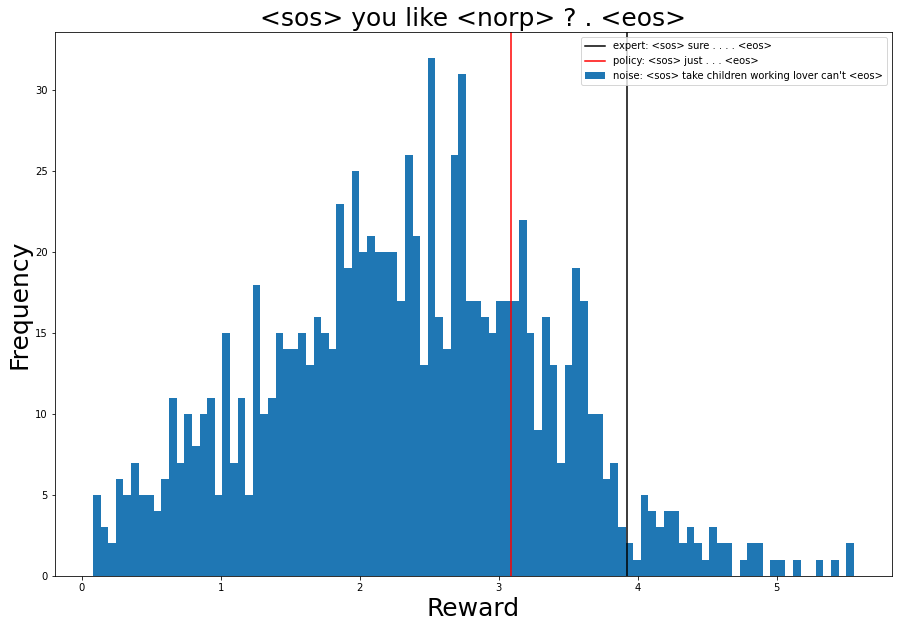

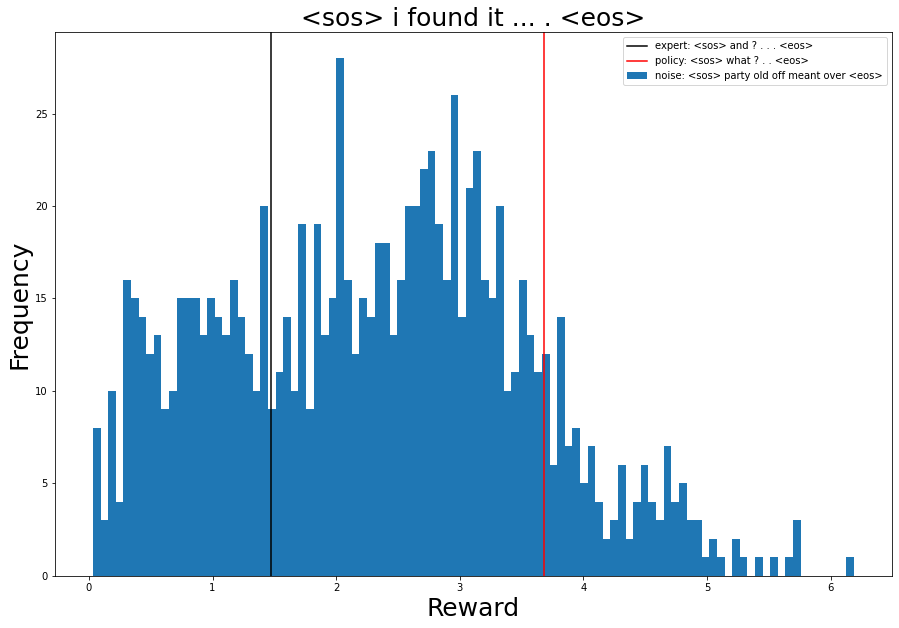

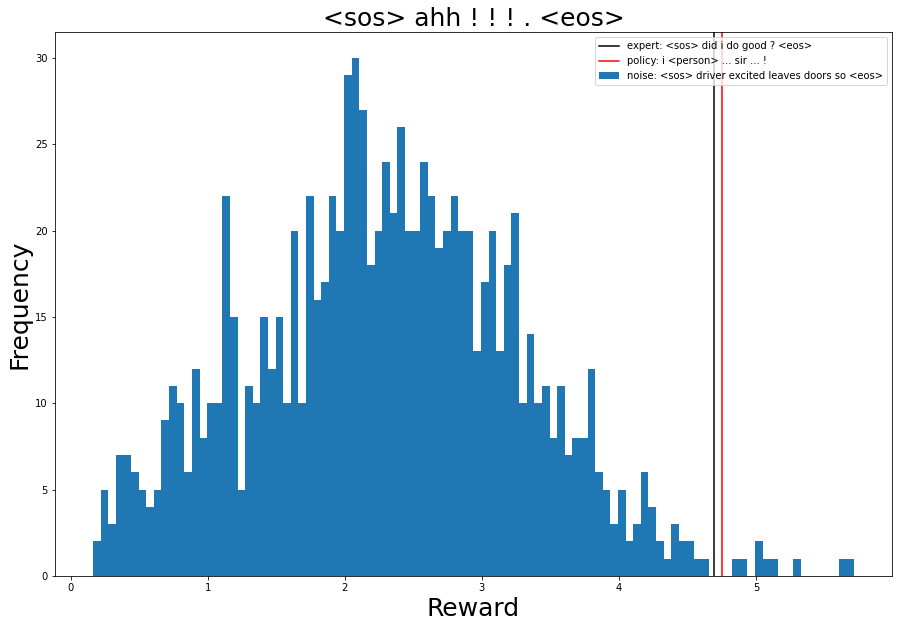

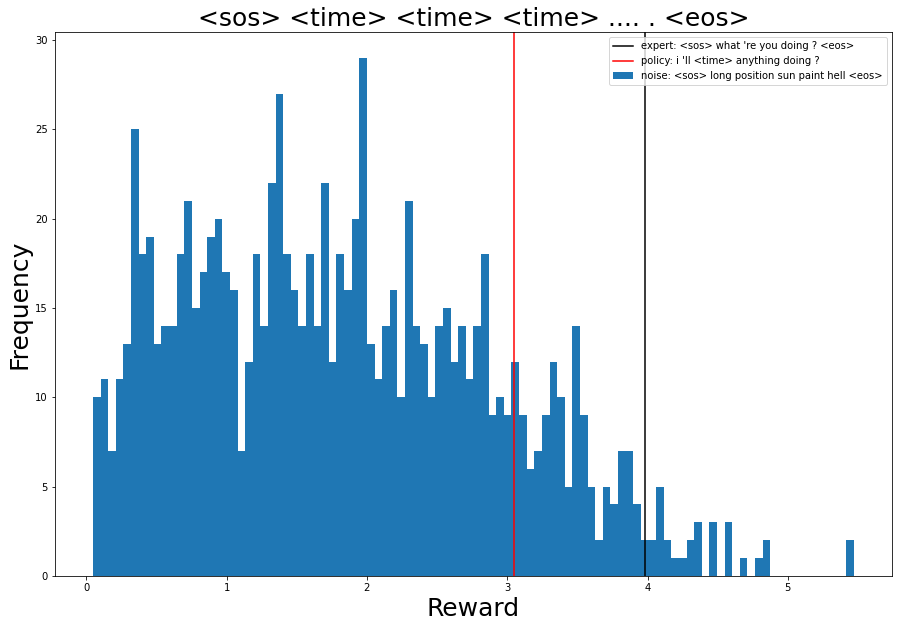

In [47]:
for step in range(1):
    trajectories = random.sample(d.items(),k=500)
    for (index, vects) in trajectories:
        input_state, expert_action = vects
        input_state = torch.cat((torch.LongTensor([sos_ind]), 
                                 input_state,
                                 torch.LongTensor([eos_ind])), 
                                 dim=0).to(device)
        expert_action = torch.cat((torch.LongTensor([sos_ind]), 
                                expert_action, 
                                torch.LongTensor([eos_ind])), 
                               dim=0).to(device)
        action_probs =  get_action_probs(agent, input_state, sos_ind, eos_ind, SEQ_LEN, device)
        action, action_log_probs = get_action(action_probs)
        action = action.detach()
        action = pad_action(action)
       # print(get_reward(discrim,input_state,expert_action), get_reward(discrim,input_state,action))
        expert_tokens = " ".join([words[int(ind)] for ind in expert_action])
        action_tokens = " ".join([words[int(ind)] for ind in action])
        state_tokens = " ".join([words[int(ind)] for ind in input_state])
        if get_reward(discrim,input_state,action) > 3: 
            i = 0
            rewards = []
            best_action = get_reward(discrim,input_state,expert_action)
            while i < 1000:

                random_inputs = [1929, random.randint(a=0,b=1928),random.randint(a=0,b=1928),random.randint(a=0,b=1928),random.randint(a=0,b=1928),random.randint(a=0,b=1928), 1930]
                random_action = torch.Tensor(random_inputs).long().cuda()
                random_reward = get_reward(discrim,input_state,random_action)
                rewards.append(random_reward)
                if random_reward > best_action:
                    print("New best!")
                    random_tokens = [words[int(ind)] for ind in random_action]
                    best_action = random_reward
                    print(random_tokens)


                i += 1

            plt.figure(figsize = (15,10))
            plt.hist(rewards,bins=100,label='noise: ' + " ".join(random_tokens))
            plt.axvline(get_reward(discrim,input_state,expert_action),color='k',label='expert: ' +expert_tokens )
            plt.axvline(get_reward(discrim,input_state,action),color='r',label='policy: ' + action_tokens)

            plt.xlabel("Reward",fontsize=25)
            plt.ylabel("Frequency",fontsize=25)
            state_tokens = " ".join([words[int(ind)] for ind in input_state])
            plt.title(state_tokens,fontsize=25)
            plt.legend(loc='upper right')

           # break